# Required libraries and setup

In [19]:
__author__ = 'j'
import distance
from sklearn import svm, linear_model
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import roc_curve, auc,f1_score
import Levenshtein as lev
import numpy as np
import pandas as pd
import pylab as plt
import seaborn as sns
%matplotlib inline
# These are the "Tableau 20" colors as RGB.
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]

# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.
for i in range(len(tableau20)):
    r, g, b = tableau20[i]
    tableau20[i] = (r / 255., g / 255., b / 255.)

# Test and train set (required files)
There are two databases of movies: **"./D/database_1.csv"** and **"./D/database_2.csv"**

From there I created small train and test sets by hand: **"./D/train.csv"**,  **"./D/test.csv"**

In [39]:
!mkdir D

mkdir: cannot create directory ‘D’: File exists


# All distance functions required

In [30]:
def jaccard(set_1, set_2):
    """
    :param set_1: set of characters string 1
    :param set_2: set of characters string 2
    :return: jaccard distance
    """
    n = len(set_1.intersection(set_2))
    return n / float(len(set_1) + len(set_2) - n)

def dice_coefficient(a,b,lenGram=2):
    """
    :param a: string 1
    :param b: string 2
    :param lenGram: length of the n-grams
    :return: dice score

    From Rossetta code
    """
    if not len(a) or not len(b): return 0.0
    """ quick case for true duplicates """
    if a == b: return 1.0
    """ if a != b, and a or b are single chars, then they can't possibly match """
    if len(a) == 1 or len(b) == 1: return 0.0

    """ use python list comprehension, preferred over list.append() """
    a_bigram_list = [a[i:i+lenGram] for i in range(len(a)-1)]
    b_bigram_list = [b[i:i+lenGram] for i in range(len(b)-1)]

    a_bigram_list.sort()
    b_bigram_list.sort()

    # assignments to save function calls
    lena = len(a_bigram_list)
    lenb = len(b_bigram_list)
    # initialize match counters
    matches = i = j = 0
    while (i < lena and j < lenb):
        if a_bigram_list[i] == b_bigram_list[j]:
            matches += lenGram
            i += 1
            j += 1
        elif a_bigram_list[i] < b_bigram_list[j]:
            i += 1
        else:
            j += 1

    score = float(matches)/float(lena + lenb)
    return score


def cosineBigrams(a,b,dictTrainBigrams,tfidf_matrix_trainBigrams,lenGram=3):
    """
    :param a: string 1
    :param b: string 2
    :param dictTrainBigrams: Dictionary of bigrams  to find index quickly
    :param tfidf_matrix_trainBigrams:  Weigths of bigrrams
    :param lenGram:  Length of n-grams (3)
    :return: cosine similarity (angle between vectors)
    """
    a = a.lower().rstrip()
    b = b.lower().rstrip()
    st1 = ' '.join([elem for elem in [a[i:i+lenGram] for i in range(len(a)-1)] if len(elem) == lenGram])
    st2 = ' '.join([elem for elem in [b[i:i+lenGram] for i in range(len(b)-1)] if len(elem) == lenGram])
    ind_a = dictTrainBigrams[st1]
    ind_b = dictTrainBigrams[st2]
    score = cosine_similarity(tfidf_matrix_trainBigrams[ind_a:ind_a+1], tfidf_matrix_trainBigrams[ind_b:ind_b+1])
    return score

def cosineWords(a,b,dictTrain,tfidf_matrix_train):
    """
    :param a: string 1
    :param b: string 2
    :param dictTrain: Dictionary of wors to find index quickly
    :param tfidf_matrix_train: Weights of words
    :return: cosine similarity (angle between vectors)
    """
    ind_a = dictTrain[a.lower().rstrip()]
    ind_b = dictTrain[b.lower().rstrip()]
    score = cosine_similarity(tfidf_matrix_train[ind_a:ind_a+1], tfidf_matrix_train[ind_b:ind_b+1])
    return score


# Create TF-IDF

In [33]:
def read_words(database1,database2):
    ## Bag of words
    with open(database1) as f:
        train_set1 = [line.lower().rstrip() for line in f]
    with open(database2) as f:
        train_set2 = [line.lower().rstrip() for line in f]

    train_set = sorted(list(set(train_set1 + train_set2)))
    return train_set

def create_trigrams(train_set,lenGram):
    train_setNgrams = []
    for mov in train_set:
        temp = [mov[i:i+lenGram] for i in range(len(mov)-1)]
        temp = [elem for elem in temp if len(elem) == lenGram]
        train_setNgrams.append(' '.join(temp))

    train_setNgrams = sorted(list(set(train_setNgrams)))
    
    return train_setNgrams

def createTFIDF(database1,database2,lenGram  = 3):
    ## Words
    train_set = read_words(database1,database2)

    # Create dictionary to find movie faster and find weights
    dictTrain = dict(zip(train_set,range(len(train_set))))
    tfidf_vectorizer = TfidfVectorizer()
    tfidf_matrix_train = tfidf_vectorizer.fit_transform(train_set)

    ## Tri-grams
    train_setNgrams = create_trigrams(train_set,lenGram)
    
    # Create dictionary to find movie faster and find weights
    dictTrainNgrams = dict(zip(train_setNgrams,range(len(train_setNgrams))))
    tfidf_vectorizerNgrams = TfidfVectorizer()
    tfidf_matrix_trainNgrams = tfidf_vectorizerNgrams.fit_transform(train_setNgrams)

    return [tfidf_matrix_train,dictTrain,tfidf_matrix_trainNgrams,dictTrainNgrams,lenGram]

In [34]:
database1 = "./D/database_1.csv"
database2 = "./D/database_2.csv"
tfidf_matrix_train,dictTrain,tfidf_matrix_trainBigrams,dictTrainBigrams,lenGram = createTFIDF(database1,database2)

# Train (find all distances)

In [45]:
def find_distances(st1,st2):
    """
    Find distances between two strings
    Types of distances: 
        "Lev","Jaro","Jaro-Winkler","Ratio","Sorensen","Jaccard","Lev1","Lev2","Dice_2","Dice_3","Dice_4","cosineWords","cosineBigrams"
    """
    
    return [1.-(lev.distance(st1,st2)*2/(len(st1)+len(st2))),
                    lev.jaro(st1,st2),
                    lev.jaro_winkler(st1,st2),
                    lev.ratio(st1,st2),
                    distance.sorensen(st1,st2),
                    jaccard(set(st1),set(st2)),
                    1. - distance.nlevenshtein(st1,st2,method=1),
                    1. - distance.nlevenshtein(st1,st2,method=2),
                    dice_coefficient(st1,st2,lenGram=2),
                    dice_coefficient(st1,st2,lenGram=3),
                    dice_coefficient(st1,st2,lenGram=4),
                    cosineWords(st1,st2,dictTrain,tfidf_matrix_train),
                    cosineBigrams(st1,st2,dictTrainBigrams,tfidf_matrix_trainBigrams,lenGram)]

def train(train_data_file,tfidf_matrix_train,dictTrain,tfidf_matrix_trainBigrams,dictTrainBigrams,lenGram,sep="\t"):
    """
    find distances and train svm and logit prediction with the train data
    """
    allTrainX = list()
    allTrainY = list()
    with open(train_data_file) as f:
        for line in f:
            lin = line.split(sep)

            st1 = lin[0].lower()
            st2 = lin[1].lower()

            temp = find_distances(st1,st2)

            allTrainX.append(temp)
            allTrainY.append(int(lin[2]))


    X = np.array(allTrainX,dtype=float)
    y = np.array(allTrainY,dtype=float)
    clf = svm.LinearSVC(C=1.,dual=False,loss='l2', penalty='l1')
    clf2 = linear_model.LogisticRegression(C=1.,dual=False, penalty='l1')
    clf.fit(X, y)
    clf2.fit(X, y)
    weights = np.array(clf.coef_[0])
    print(weights)
    weights = np.array(clf2.coef_[0])
    print(weights)


    return clf,clf2

In [47]:
train_data_file = "./D/train.csv" #must be a tab separated file
clf,clf2 = train(train_data_file,tfidf_matrix_train,dictTrain,tfidf_matrix_trainBigrams,dictTrainBigrams,lenGram,sep="\t")

[-2.58195528  2.28403607 -0.85043568  0.          0.         -0.06883523
  0.          0.          3.9384034   0.31261506  0.          0.87452395
  0.23173531]
[-2.21573066  0.          0.          0.          0.          0.          0.
  0.          3.79791187  2.12736203  0.          2.98195502  1.21855803]


/home/javiergb/Programs/anaconda3/lib/python3.5/site-packages/sklearn/svm/classes.py:199: DeprecationWarning: loss='l2' has been deprecated in favor of loss='squared_hinge' as of 0.16. Backward compatibility for the loss='l2' will be removed in 1.0
  DeprecationWarning)


# Test and plot results (requires test file)

In [68]:
def test(test_data_file,tfidf_matrix_train,dictTrain,tfidf_matrix_trainBigrams,dictTrainBigrams,lenGram,clf1,clf2,sep="\t"):
    """
    find distances, svm and logit prediction for the test data
    """
    with open(test_data_file) as infile:
        for i,line in enumerate(infile):
            pass

    dimMatrix = 16
    predict = np.zeros((i+1,dimMatrix))

    with open(test_data_file) as infile:
        for i,line in enumerate(infile):
            lin = line.rstrip().split(sep)

            ## create same vector with more distances
            st1 = lin[0].lower()
            st2 = lin[1].lower()

            temp = find_distances(st1,st2)
 
            predict[i,:-3] = temp
            #Predict SVM
            predict[i,-3] = clf1.decision_function(np.array(temp,dtype=float))
            #Predict Logit
            predict[i,-2] = clf2.decision_function(np.array(temp,dtype=float))
            #Real
            predict[i,-1] = lin[-1]

    return predict


In [69]:
import warnings
warnings.filterwarnings(action='once')

In [70]:
test_data_file = "./D/test.csv"
predict = test(test_data_file,tfidf_matrix_train,dictTrain,tfidf_matrix_trainBigrams,dictTrainBigrams,lenGram,clf,clf2,sep="\t")

/home/javiergb/Programs/anaconda3/lib/python3.5/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


# Plot results

In [94]:
def barplot(x,y,xlabel,ylabel,xticks):
    fig = plt.figure(figsize=(9,6))
    ax = fig.add_subplot(111)
    ax.bar(range(x),y)
    
    plt.xticks(np.arange(x)+0.5,xticks,rotation=45)
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    plt.legend(loc=2)
    plt.show()
    
def plot(predict):
    """
    Plot the results based on predict (last column real, other columns as in find_distances + svm + logit )
    """
    labelsM = ["Lev","Jaro","Jaro-Winkler","Ratio","Sorensen","Jaccard","Lev1","Lev2","Dice_2","Dice_3","Dice_4","cosineWords","cosineBigrams","SVM","Logit"]
    dimMatrix = len(labelsM)
    
    
    f1matrix = np.zeros((100,dimMatrix))

    iC = -1
    for i in np.linspace(0,1,100):
        iC += 1
        for j in range(dimMatrix):
            t = np.array(predict[:,j])
            if j >= dimMatrix-2:
                t = (t - np.min(t))/(np.max(t)-np.min(t))
            f1matrix[iC,j] = f1_score(y_pred=t>i ,y_true=predict[:,-1])
    
    F1scores = np.max(f1matrix,axis=0)
    barplot(dimMatrix,F1scores,xlabel="Parameter",ylabel="F1 score",xticks=labelsM)
    
    fig = plt.figure(figsize=(9,6))
    ax = fig.add_subplot(111)
    AUCScores = []
    for j in range(dimMatrix):
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(predict[:,-1], predict[:,j])
        AUCScores.append(auc(fpr, tpr))

        # Plot ROC curve
        ax.plot(fpr, tpr, label=labelsM[j],color=tableau20[j])
        ax.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('ROC Curve')

    plt.legend(loc=2)

    plt.show()

    
    barplot(dimMatrix,AUCScores,xlabel="Parameter",ylabel="Area Under Curve",xticks=labelsM)


/home/javiergb/Programs/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/javiergb/Programs/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


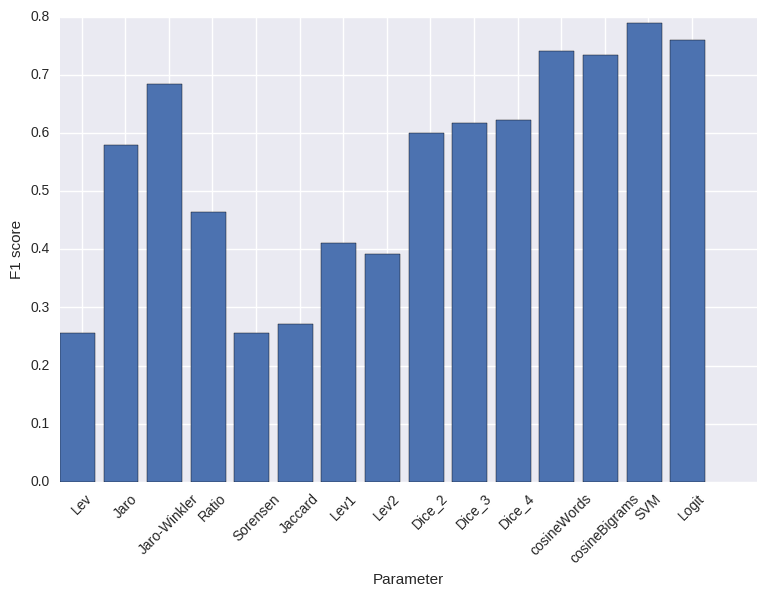

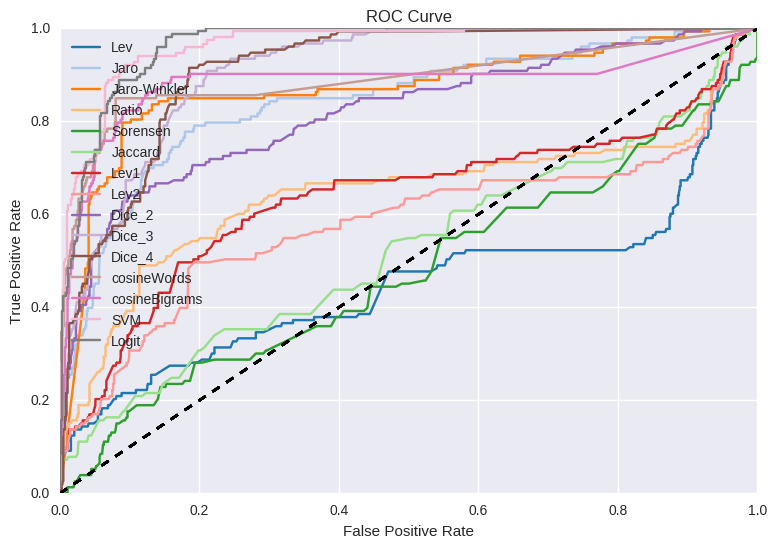

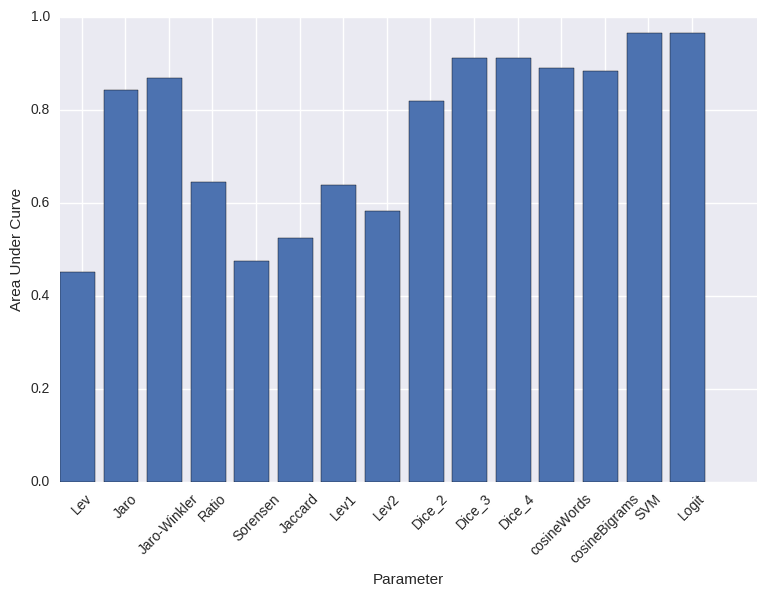

In [95]:

plot(predict)